In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [32]:
pip install --upgrade pandas_datareader


In [9]:
import yfinance as yf

msft = yf.Ticker("MSFT")
hist = msft.history(period="5y")  # or .history(start="2008-01-01", end="2023-12-31")
print(hist.columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [22]:
import yfinance as yf

stocks = ['HSBC', 'JPM', 'TSLA', 'WMT', 'AMZN', 'COST']
adj_data = yf.download(
    stocks,
    start="2008-01-01",
    end="2025-05-18",
    auto_adjust=True, # <-- This adjusts 'Close', 'Open', 'High', 'Low' for splits/dividends,
    progress=False
)

# Now, use the adjusted close from 'Close'
adj_close = adj_data['Close']
print(adj_close.head())



Ticker        AMZN       COST       HSBC        JPM  TSLA        WMT
Date                                                                
2008-01-02  4.8125  47.333927  32.242767  27.130796   NaN  10.829194
2008-01-03  4.7605  46.625362  32.234947  26.944220   NaN  10.709130
2008-01-04  4.4395  45.604233  31.777361  26.333015   NaN  10.556734
2008-01-07  4.4410  45.833469  32.133274  26.596804   NaN  10.750686
2008-01-08  4.3940  45.131863  31.523123  25.541672   NaN  10.614460


In [26]:
adj_close

Ticker,AMZN,COST,HSBC,JPM,TSLA,WMT
Date,,,,,,
2008-01-02,4.812500,47.333927,32.242767,27.130796,NaN,10.829194
2008-01-03,4.760500,46.625362,32.234947,26.944220,NaN,10.709130
2008-01-04,4.439500,45.604233,31.777361,26.333015,NaN,10.556734
2008-01-07,4.441000,45.833469,32.133274,26.596804,NaN,10.750686
2008-01-08,4.394000,45.131863,31.523123,25.541672,NaN,10.614460
...,...,...,...,...,...,...
2025-05-12,208.639999,1016.150024,58.240002,260.049988,318.380005,96.750000
2025-05-13,211.369995,999.030029,58.340000,263.010010,334.070007,95.879997
2025-05-14,210.250000,991.539978,58.259998,265.640015,347.679993,96.830002


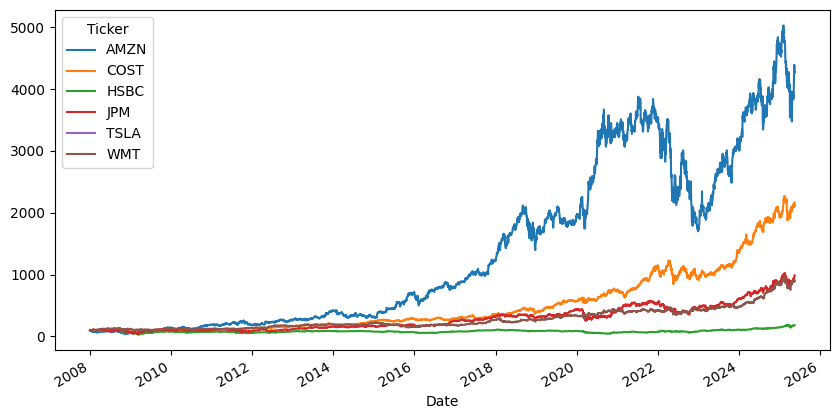

In [27]:
# Plotting Normalized returns
(adj_close / adj_close.iloc[0] * 100).plot(figsize=(10, 5))
plt.show()

In [38]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks) )
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    # Corrected indentation: these lines should be part of efficient_return
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    # Corrected indentation: this return should be part of efficient_return
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=adj_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=adj_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)

def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=adj_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=adj_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    target = np.linspace(rp_min, 0.40, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)

## Case 1: An Investor wants the portfolio with the lowest level of risk.

## Case 2: An Investor wants the optimum portfolio giving the optimum combination of risk and returns.

In [39]:
returns = adj_close.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.01136

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.27
Annualised Volatility: 0.23


Ticker       AMZN   COST  HSBC   JPM   TSLA   WMT
allocation  13.83  33.66  0.44  2.93  21.64  27.5
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.18


Ticker      AMZN   COST   HSBC   JPM  TSLA    WMT
allocation  5.45  17.03  20.22  0.38  3.15  53.76


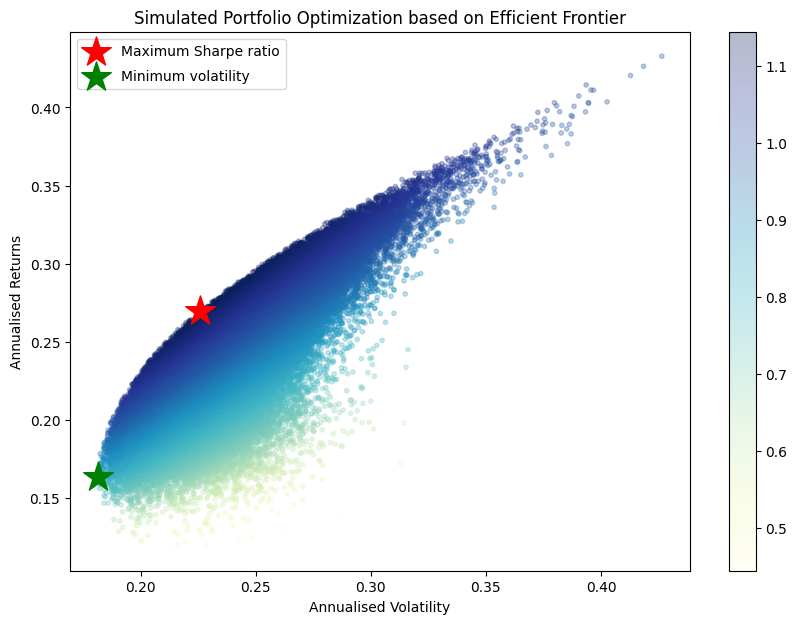

In [40]:
# Simulating Portfolios based on Efficient Frontier
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

***The green star represents the portfolio which is the least volatile, i.e. the portfolio of Case 1. The red star is the optimum portfolio where the Sharpe ratio is the maximum (Case 2). From the plot of the randomly simulated portfolios, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called the efficient frontier.***

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.28
Annualised Volatility: 0.23


Ticker       AMZN   COST  HSBC   JPM   TSLA    WMT
allocation  13.92  39.23   0.0  2.16  23.33  21.36
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.18


Ticker      AMZN   COST   HSBC  JPM  TSLA    WMT
allocation  2.43  25.37  20.62  0.0  2.15  49.43


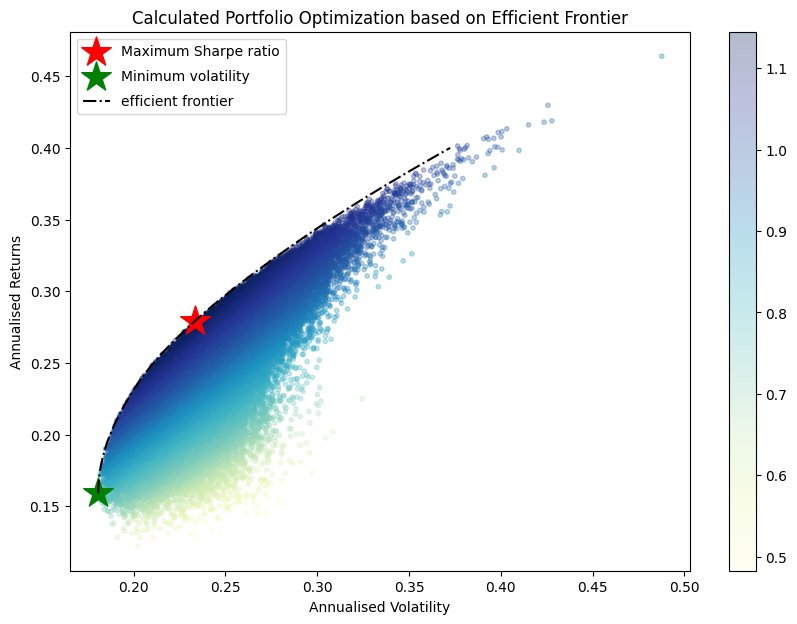

In [41]:
# Calculating Portfolios based on Efficient Frontier
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

## Case 3: An Investor wants a portfolio giving a return not less than the minimum acceptable return fixed by the investor.

In [42]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=adj_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=adj_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    #print ("Minimum Volatility Portfolio Allocation\n")
    #print ("Annualised Return:", round(rp_min,2))
    #print ("Annualised Volatility:", round(sdp_min,2))
    #print ("\n")
    #print (min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=adj_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=adj_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    #print ("-"*80)
    #print ("Minimum Volatility Portfolio Allocation\n")
    #print ("Annualised Return:", round(rp_min,2))
    #print ("Annualised Volatility:", round(sdp_min,2))
    #print ("\n")
    #print (min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    target = np.linspace(rp_min, 0.60, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing = 0.8)

In [43]:
# Assuming a minimum acceptable return requirement of 20%, we will find the optimum portfolio using the SF ratio.

returns = adj_close.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000
risk_free_rate = 0.20

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.5
Annualised Volatility: 0.53


Ticker       AMZN  COST  HSBC  JPM   TSLA  WMT
allocation  11.92   0.0   0.0  0.0  88.08  0.0


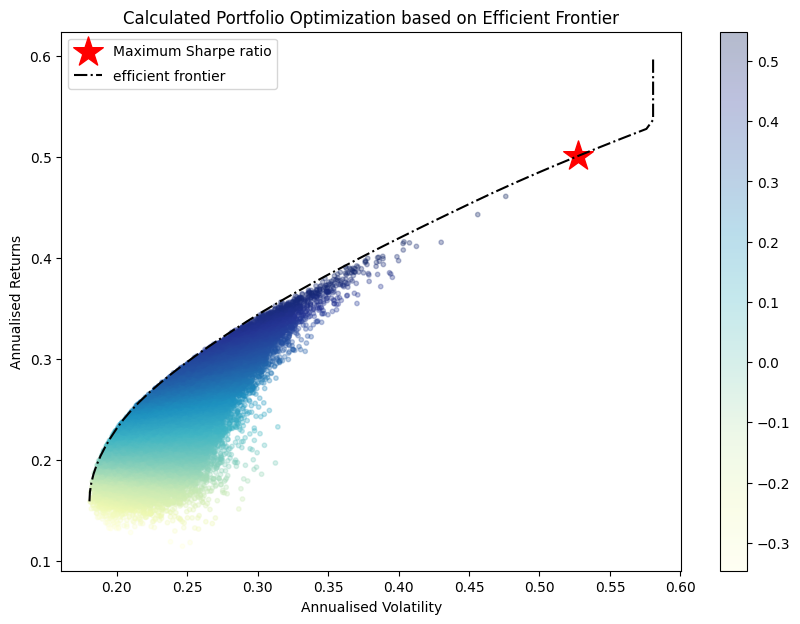

In [46]:
# Calculating Portfolios based on Efficient Frontier
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [54]:
pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 15.9 MB/s eta 0:00:00


In [59]:
def utility_optimal_portfolio(data,risk_aversion_coeff):
    # Importing libraries
    from pypfopt import EfficientFrontier
    from pypfopt import risk_models
    from pypfopt import expected_returns
    from pypfopt import objective_functions

    # Expected Returns
    mu = expected_returns.mean_historical_return(adj_close)
    # Expected Volatility
    Sigma = risk_models.sample_cov(adj_close)
    ef = EfficientFrontier(mu, Sigma)  # setup
    ef.add_objective(objective_functions.L2_reg)  # add a secondary objective
    weights = ef.max_quadratic_utility(risk_aversion=risk_aversion_coeff, market_neutral=False)  # find the portfolio that maximizes utility
    ret,vol,sharpe_r = ef.portfolio_performance(risk_free_rate=0.01125)
    # loop to iterate for values
    res = dict()
    for key in weights:
    # rounding to K using round()
        res[key] = round(weights[key], 2)

    return "Allocation " + str(res),'Annualised Reutrn ' + str(round(ret,2)),'Annualised Volatility ' + str(round(vol,2)),'Sharpe Ratio ' + str(round(sharpe_r,2))

# Aggressive Investor
utility_optimal_portfolio(adj_close,1)

("Allocation {'AMZN': 0.18, 'COST': 0.18, 'HSBC': 0.09, 'JPM': 0.14, 'TSLA': 0.26, 'WMT': 0.15}",
 'Annualised Reutrn 0.23',
 'Annualised Volatility 0.25',
 'Sharpe Ratio 0.89')

In [60]:
utility_optimal_portfolio(adj_close,4)

("Allocation {'AMZN': 0.17, 'COST': 0.2, 'HSBC': 0.11, 'JPM': 0.13, 'TSLA': 0.2, 'WMT': 0.19}",
 'Annualised Reutrn 0.21',
 'Annualised Volatility 0.23',
 'Sharpe Ratio 0.88')

In [61]:
# Risk-Averse Investor
utility_optimal_portfolio(adj_close,10)

("Allocation {'AMZN': 0.15, 'COST': 0.23, 'HSBC': 0.13, 'JPM': 0.11, 'TSLA': 0.14, 'WMT': 0.24}",
 'Annualised Reutrn 0.19',
 'Annualised Volatility 0.21',
 'Sharpe Ratio 0.87')